In [1]:
import pandas as pd
import zipfile 
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import os
import re
from keras.utils import image_dataset_from_directory
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Resizing, Rescaling, Input, Dropout, BatchNormalization
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import tensorflow as tf
%matplotlib inline

In [ ]:
file_name = "data.zip"
zip_ref = zipfile.ZipFile(file_name, "r")
zip_ref.extractall("datos")
zip_ref.close()

In [2]:
desiredLength = 16000 * 8
def melSpectrogram(dir, file):
    #librosa.load(f'{dir}\{file}')
    signal, sr = librosa.load(f'{dir}/{file}', sr=16000)
    n_fft = 2048
    hop_length = 512
    padding = desiredLength - len(signal) #cantidad de tiempo que falta
    signal = np.concatenate([np.zeros((padding)), signal])
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.min)
    return power_to_db

In [3]:
data_dir = "audio"

In [4]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust","surprised"]
index = dict(enumerate(emotions,start=1))
for emotion in emotions:
    os.mkdir(f"{data_dir}/{emotion}")

In [5]:
for actor in os.listdir("./audio"):
    if actor not in emotions:
        for file in os.listdir(f"./audio/{actor}"):
            if file[-3:] != "png":
                matrix = melSpectrogram(f"./audio/{actor}/", file)
                emotion = int(file[:8][-2:])
                np.save(f'./audio/{index[emotion]}/{file[:-4]}', matrix)

Model training

In [2]:
dataset_dir = "./Dataset/"

In [3]:
emotions = ["happy", "sad", "fearful", "angry","surprised", "neutral"]
full_data = []
labels    = []
for label in os.listdir(dataset_dir):
    intermediate = list()
    for file in os.listdir(dataset_dir+"/"+label):
        intermediate.append([np.load(dataset_dir +  label+"/" +file), emotions.index(label)])
    # Take the minimum size for each class, which is 192.
    full_data.append(np.array(intermediate)[np.random.choice(np.arange(len(intermediate)), size=192, replace=False)])

c:\Users\lumin\anaconda3\envs\bot\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


In [4]:
full_data = np.array(full_data).reshape(192*6, 2)

In [5]:
np.random.shuffle(full_data)

In [6]:
# Split into train and validation
trainInd = int(len(full_data) * 0.7)
train = full_data[:trainInd]
validation = full_data[trainInd:]

In [7]:
scaler = MinMaxScaler()
def separate(array):
    audios = []
    labels  =  []
    for audio, label in array:
        audios.append(np.expand_dims(audio, axis=2))
        labels.append(label)
    return [np.array(audios), np.array(labels)]

In [8]:
train = separate(full_data)
validation = separate(validation)

In [29]:
scaler.fit((np.concatenate([train[0], validation[0]])).reshape(-1,1))

MinMaxScaler()

In [30]:
aux = []
for image in train[0]:
    aux.append(scaler.transform(np.squeeze(image).reshape(-1,1)).reshape((128,train[0][0].shape[1],1)))
aux = np.array(aux)

In [31]:
train[0] = aux

In [32]:
model = Sequential()
model.add(Input((128, 251, 1)))
model.add(Resizing(224,224))

model.add(Conv2D(filters= 32, kernel_size= (3,3), activation="relu", padding= "same",strides=(1,1)))
model.add(Conv2D(filters= 32, kernel_size= (3,3), activation="relu", padding= "same",strides=(1,1)))

model.add( MaxPool2D(pool_size= (2,2),strides=(2,2)))
model.add( Conv2D(64,(3,3), activation="relu",padding= "same",strides=(1,1)))
model.add( Conv2D(64,(3,3), activation="relu",padding= "same",strides=(1,1)))

model.add(MaxPool2D(pool_size= (2,2),strides=(2,2)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))

model.add( MaxPool2D(pool_size= (2,2),strides=(2,2)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))

model.add( MaxPool2D(pool_size= (2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(6, activation="softmax"))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                        

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer= Adam(learning_rate=0.00001), metrics=["accuracy"])

In [35]:
train[0].shape

(1152, 128, 251, 1)

In [36]:
historico = model.fit(x=train[0], y=train[1],batch_size=5, epochs=200)

Epoch 1/200
231/231 [==============================] - 15s 28ms/step - loss: 1.7915 - accuracy: 0.1623
Epoch 2/200
231/231 [==============================] - 6s 25ms/step - loss: 1.7872 - accuracy: 0.1701
Epoch 3/200
231/231 [==============================] - 6s 25ms/step - loss: 1.7289 - accuracy: 0.2578
Epoch 4/200
231/231 [==============================] - 6s 25ms/step - loss: 1.6649 - accuracy: 0.2812
Epoch 5/200
231/231 [==============================] - 6s 25ms/step - loss: 1.6195 - accuracy: 0.3160
Epoch 6/200
231/231 [==============================] - 6s 25ms/step - loss: 1.6077 - accuracy: 0.3134
Epoch 7/200
231/231 [==============================] - 6s 26ms/step - loss: 1.6009 - accuracy: 0.3003
Epoch 8/200
231/231 [==============================] - 6s 26ms/step - loss: 1.5777 - accuracy: 0.3377
Epoch 9/200
231/231 [==============================] - 6s 26ms/step - loss: 1.5586 - accuracy: 0.3325
Epoch 10/200
231/231 [==============================] - 6s 26ms/step - loss: 1.55

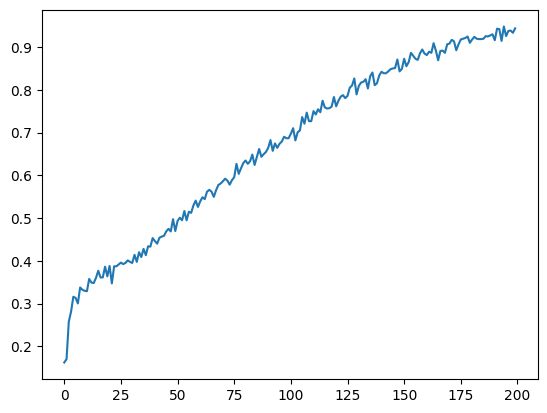

In [37]:
plt.plot(historico.history['accuracy'])

In [38]:
model.save('modelNoImage.h5')

In [39]:
train[0][0].shape

(128, 251, 1)

In [41]:
[ np.sum(x) for x in model.predict(train[0])]

36/36 [==============================] - 1s 36ms/step


[1.0,
 1.0,
 1.0000001,
 0.99999994,
 1.0,
 1.0,
 1.0,
 0.9999999,
 0.99999994,
 1.0,
 1.0,
 1.0000001,
 1.0,
 0.99999994,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000001,
 0.99999994,
 1.0000001,
 0.99999994,
 0.99999994,
 0.99999994,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 1.0,
 0.99999994,
 1.0000001,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000001,
 0.99999994,
 1.0,
 0.9999998,
 1.0,
 0.99999994,
 1.0,
 0.9999999,
 1.0,
 0.99999994,
 1.0000001,
 1.0000001,
 0.9999999,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000001,
 1.0,
 1.0000001,
 1.0,
 0.9999999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 1.0,
 0.9999999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000001,
 1.0,
 0.99999994,
 1.0,
 0.99999994,
 1.0000001,
 0.99999994,
 1.0,
 1.0,
 1.0000001,
 1.0,
 1.0,
 1.0,
 1.0000001,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000001,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999998,
 0.99999994,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 0.99999994,
 1.0000001,
 0.99999994,
 1.0,
 1.0000001,
 

In [45]:
a = model.predict(train[0])[0]

36/36 [==============================] - 1s 31ms/step


In [21]:
imgToPredict = train[0][0]

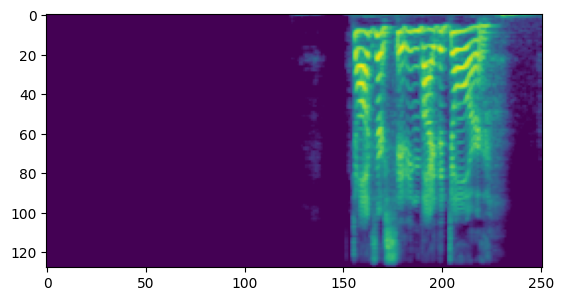

In [22]:
plt.imshow(imgToPredict)
plt.show()

In [23]:
model.predict(np.expand_dims(imgToPredict, axis=0))

1/1 [==============================] - 1s 669ms/step


array([[9.9992180e-01, 4.7696290e-07, 3.6463955e-06, 7.4049232e-05,
        1.0074758e-08, 3.9408192e-09]], dtype=float32)

In [24]:
model.predict(np.expand_dims(train[0][45], axis=0))

1/1 [==============================] - 0s 18ms/step


array([[9.8627520e-01, 1.3512659e-03, 1.5451114e-03, 1.0749600e-04,
        1.0715466e-02, 5.4742736e-06]], dtype=float32)

In [1]:
import numpy as np

In [9]:
a = np.array([9.8627520e-01, 1.3512659e-03, 1.5451114e-03, 1.0749600e-04,
        1.0715466e-02, 5.4742736e-06])

In [10]:
a

array([9.8627520e-01, 1.3512659e-03, 1.5451114e-03, 1.0749600e-04,
       1.0715466e-02, 5.4742736e-06])

In [11]:
np.exp(a)/(np.sum(np.exp(a)))

array([0.34843719, 0.13013001, 0.13015524, 0.12996826, 0.1313543 ,
       0.129955  ])